# PM2 Task C - Conditioning: Analysis and Improvement

Part A - Typical Condition Numbers and Practical Interpretation
- Compute the condition number for small-large grids
- Analyze parameter uncertainty impact
- Calculate digits of trust 
- Is this enough precision for our goals?

Part B - Operating Point Pitfalls
- System is fully linear
- Jacobian is constant
- No special operating points cause ill-conditioning 

Part C - Parameter Pitfalls
- Identify which parameters can affect condiiton number 
- Identify which parameters cannot affect condition number
- Modify parameters until condition number increases beyond threshold
- Recovery analysis: turn broken parameters back slowly, observe condition number recovery
- What is the primary driver?

In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from numpy.linalg import cond as dense_cond

# Project imports
from getParam_Sonar import getParam_Sonar

# Helpers
def build_C(p):
    # Selector matrix C (H x 2N) that picks pressure at hydrophones.
    H = p['hydrophones']['n_phones']
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    C = np.zeros((H, 2*N))
    z_pos = p['hydrophones']['z_pos']
    for h, x_idx in enumerate(p['hydrophones']['x_indices']):
        if x_idx < Nx:
            k = x_idx * Nz + z_pos
            C[h, k] = 1.0
    return C

def to_dense(A):
    return A.toarray() if sp.issparse(A) else np.array(A)

def extract_L(p):
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    Lblk = A[N:, :N]
    return Lblk.toarray() if sp.issparse(Lblk) else np.array(Lblk)

def rebuild_params_like(p, **overrides):
    # Rebuild A (for alpha,c) and B (for source position) using existing structure.
    q = dict(p)
    is_sparse = sp.issparse(p['A'])
    Nx, Nz = p['Nx'], p['Nz']
    N = Nx * Nz
    A = p['A']
    # Update alpha/c by reconstructing A blocks
    alpha_new = overrides.get('alpha', p['alpha'])
    c_new = overrides.get('c', p['c'])
    c_old = p['c']
    scale = (c_new / c_old)**2 if 'c' in overrides else 1.0
    if is_sparse:
        L_blk = A[N:, :N]
        I_N = sp.eye(N, format='csr')
        L_new = L_blk * scale
        A_new = sp.bmat([[sp.csr_matrix((N, N)), I_N],
                         [L_new, -alpha_new * I_N]], format='csr')
    else:
        L_blk = A[N:, :N]
        I_N = np.eye(N)
        L_new = L_blk * scale
        A_new = np.block([[np.zeros((N, N)), I_N],
                         [L_new, -alpha_new * I_N]])
    q['A'] = A_new
    q['alpha'] = alpha_new
    q['c'] = c_new
    # Update B if sonar position overrides are provided
    si = overrides.get('sonar_ix', p['sonar_ix'])
    sj = overrides.get('sonar_iz', p['sonar_iz'])
    if ('sonar_ix' in overrides) or ('sonar_iz' in overrides):
        def idx(i,j):
            return i * Nz + j
        if is_sparse:
            B = sp.lil_matrix((2*N,1), dtype=float)
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B.tocsr()
        else:
            B = np.zeros((2*N,1))
            B[N + idx(si,sj), 0] = 1.0 / (p['dx']*p['dz'])
            q['B'] = B
        q['sonar_ix'] = si
        q['sonar_iz'] = sj
    return q

## Part A

Neglect dynamics (PM2 requirement):
- dp/dt = 0  →  w = 0
- dw/dt = c²Lp - αIw + bu  →  0 = c²Lp + bu
- Lp = -bu/c²

Note: α (damping) disappears in steady-state, so analyze cond(L) not cond(A)

Grid  3x 3 (N=   9, dx=50.000m, dz=50.000m): cond(L) = 9.7141e+00
Grid  4x 4 (N=  16, dx=33.333m, dz=33.333m): cond(L) = 1.7787e+01
Grid  5x 5 (N=  25, dx=25.000m, dz=25.000m): cond(L) = 2.8171e+01
Grid  7x 7 (N=  49, dx=16.667m, dz=16.667m): cond(L) = 5.5871e+01
Grid 10x10 (N= 100, dx=11.111m, dz=11.111m): cond(L) = 1.1473e+02
Grid 15x15 (N= 225, dx=7.143m, dz=7.143m): cond(L) = 2.5913e+02
Grid 20x20 (N= 400, dx=5.263m, dz=5.263m): cond(L) = 4.6151e+02
Grid 25x25 (N= 625, dx=4.167m, dz=4.167m): cond(L) = 7.2191e+02
Grid 30x30 (N= 900, dx=3.448m, dz=3.448m): cond(L) = 1.0404e+03
Grid 40x40 (N=1600, dx=2.564m, dz=2.564m): cond(L) = 1.8514e+03
Grid 50x50 (N=2500, dx=2.041m, dz=2.041m): cond(L) = 2.8947e+03
Grid 60x60 (N=3600, dx=1.695m, dz=1.695m): cond(L) = 4.1703e+03
Grid 70x70 (N=4900, dx=1.449m, dz=1.449m): cond(L) = 5.6781e+03
Grid 80x80 (N=6400, dx=1.266m, dz=1.266m): cond(L) = 7.4181e+03


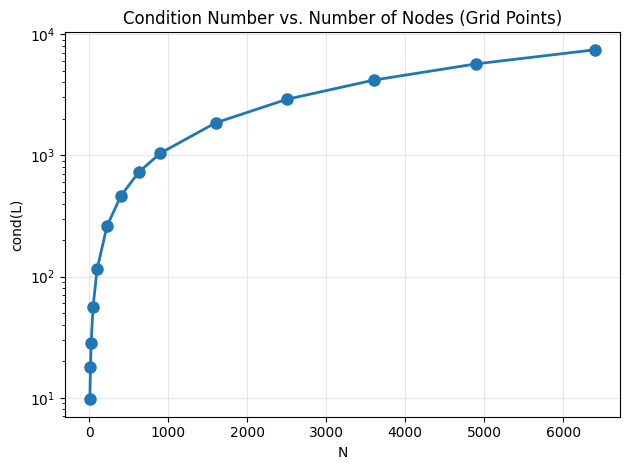

In [3]:
Lx, Lz = 100, 100
grids_to_test = [(3, 3),(4, 4),(5, 5),(7, 7),(10, 10),(15, 15),(20, 20),(25, 25),(30, 30),(40, 40),(50, 50),(60, 60),(70, 70),(80, 80)]

results = []
for Nx, Nz in grids_to_test:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True, BC=False)
    L = extract_L(p)
    N = Nx * Nz
    dx = Lx / (Nx - 1)
    dz = Lz / (Nz - 1)
    
    cond_L = dense_cond(L)
    
    results.append({'Nx': Nx, 'Nz': Nz, 'N': N, 'dx': dx, 'dz': dz, 'cond_L': cond_L})
    print(f"Grid {Nx:2d}x{Nz:2d} (N={N:4d}, dx={dx:.3f}m, dz={dz:.3f}m): " f"cond(L) = {cond_L:.4e}")

N_vals = [r['N'] for r in results]
cond_vals = [r['cond_L'] for r in results]

plt.figure()
plt.semilogy(N_vals, cond_vals, 'o-', linewidth=2, markersize=8)
plt.xlabel('N')
plt.ylabel('cond(L)')
plt.title('Condition Number vs. Number of Nodes (Grid Points)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# wavelength is 75m, so dx,dz should be < 75/2 = 37.5m

Parameter uncertainty impact: 
Very tight tolerances required... this is because Lp = -bu/c², so changing c by 1% changes L by 2%

Sound speed precision (CTD) = +-0.05 m/s --> 0.006% (typical c = 1500 m/s)

Positional precision (RTK GPS) = +-0.01 m --> 0.02% (typical L = 100 m)

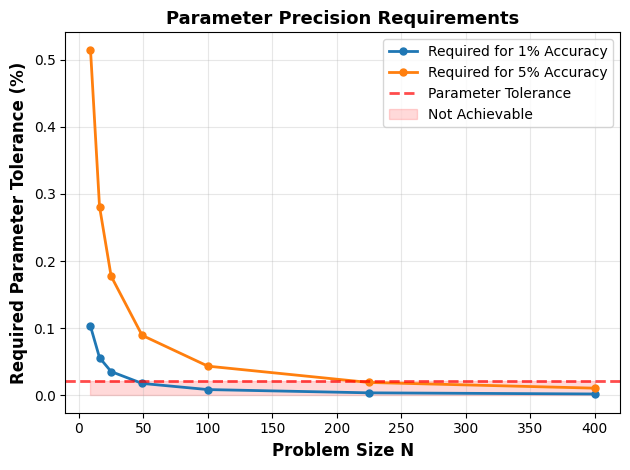

In [4]:
plt.figure()

num_show = len(N_vals)//2

tol_1 = [(0.01 / c) * 100 for c in cond_vals]
plt.plot(N_vals[:num_show], tol_1[:num_show], 'o-', linewidth=2, markersize=5, 
         label='Required for 1% Accuracy', color='C0')

tol_5 = [(0.05 / c) * 100 for c in cond_vals]
plt.plot(N_vals[:num_show], tol_5[:num_show], 'o-', linewidth=2, markersize=5, 
         label='Required for 5% Accuracy', color='C1')

combined = np.sqrt((0.006)**2 + (0.02)**2)
#combined = 0.006 # only sound speed uncertainty

plt.axhline(combined, color='r', linestyle='--', linewidth=2, alpha=0.7,
            label='Parameter Tolerance')

plt.fill_between(N_vals[:num_show], 0, combined, alpha=0.15, color='red',
                 label='Not Achievable')

plt.xlabel('Problem Size N', fontsize=12, fontweight='bold')
plt.ylabel('Required Parameter Tolerance (%)', fontsize=12, fontweight='bold')
plt.title('Parameter Precision Requirements', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, which='both', alpha=0.3)
plt.tight_layout()
plt.show()

In [5]:
print("Digits of Trust")
print(f"\n{'Grid':<10s} {'cond(L)':<12s} {'Numerical':<15s} {'Physical':<20s}")
for r in results:
    Nx, Nz = r['Nx'], r['Nz']
    cond_L = r['cond_L']
    
    # Numerical precision (perfect parameters)
    digits_num = 16 - np.log10(cond_L)

    # Physical precision (perfect parameters)
    error_phys = cond_L * combined/100
    digits_phys = -np.log10(error_phys) if error_phys < 1 else 0
    
    print(f"{Nx:2d}x{Nz:2d}      {cond_L:8.0f}     "
          f"{digits_num:6.1f} digits    "
          f"{digits_phys:6.1f} digits")

Digits of Trust

Grid       cond(L)      Numerical       Physical            
 3x 3            10       15.0 digits       2.7 digits
 4x 4            18       14.7 digits       2.4 digits
 5x 5            28       14.6 digits       2.2 digits
 7x 7            56       14.3 digits       1.9 digits
10x10           115       13.9 digits       1.6 digits
15x15           259       13.6 digits       1.3 digits
20x20           462       13.3 digits       1.0 digits
25x25           722       13.1 digits       0.8 digits
30x30          1040       13.0 digits       0.7 digits
40x40          1851       12.7 digits       0.4 digits
50x50          2895       12.5 digits       0.2 digits
60x60          4170       12.4 digits       0.1 digits
70x70          5678       12.2 digits       0.0 digits
80x80          7418       12.1 digits       0.0 digits


## Part C

What effects condition number?

#### Grid size N = Nx x Nz
- **cond(L) ~ O(N) where N = Nx × Nz**
- Finite difference Laplacian: L ~ 1/dx²
- As grid refines (Nx increases, Lx fixed):  dx = Lx/(Nx-1) decreases
- Eigenvalues of L spread over wider range
    - λ_max ~ 1/dx² (high frequency modes)
    - λ_min ~ 1/Lx² (low frequency modes)
    - cond(L) = λ_max/λ_min ~ (Lx/dx)² ~ Nx² (= N for square grids)

#### Grid aspect ratio (dx/dz) 
- **Non-uniform grids (dx ≠ dz) worsen conditioning**
- Laplacian: L ~ 1/dx² (x-direction) + 1/dz² (z-direction)
- If dx >> dz: Anisotropic stiffness
- Different directions have different eigenvalue scales
- Creates ill-conditioning
- Best practice, keep dx ≈ dz

#### Boundary absorption strength 
- **Adds damping term to boundary points**
- Only affects O(Nx + Nz) boundary nodes out of N = Nx × Nz total nodes
- Does not change the O(N) scaling but has multiplicative effects due to reflections


Grid size effect...
  Grid 10×10 (N=  100): cond = 8.40e+32
  Grid 15×15 (N=  225): cond = 4.72e+18
  Grid 20×20 (N=  400): cond = 1.14e+18
  Grid 25×25 (N=  625): cond = 3.70e+17
  Grid 30×30 (N=  900): cond = 4.49e+18
  Grid 40×40 (N= 1600): cond = 5.25e+18
  Grid 50×50 (N= 2500): cond = 6.66e+18
  Grid 60×60 (N= 3600): cond = 4.50e+18
  Grid 70×70 (N= 4900): cond = 1.09e+18
  Grid 80×80 (N= 6400): cond = 1.15e+20

Aspect ratio effect (fixed N = 400)...
  Grid 100×  4 (N=400): dx/dz =   0.03, cond = 1.59e+65
  Grid  50×  8 (N=400): dx/dz =   0.14, cond = 5.88e+35
  Grid  40× 10 (N=400): dx/dz =   0.23, cond = 1.96e+34
  Grid  25× 16 (N=400): dx/dz =   0.62, cond = 4.33e+32
  Grid  20× 20 (N=400): dx/dz =   1.00, cond = 1.14e+18
  Grid  16× 25 (N=400): dx/dz =   1.60, cond = 1.68e+18
  Grid  10× 40 (N=400): dx/dz =   4.33, cond = 5.40e+18
  Grid   8× 50 (N=400): dx/dz =   7.00, cond = 5.84e+18
  Grid   4×100 (N=400): dx/dz =  33.00, cond = 7.67e+17


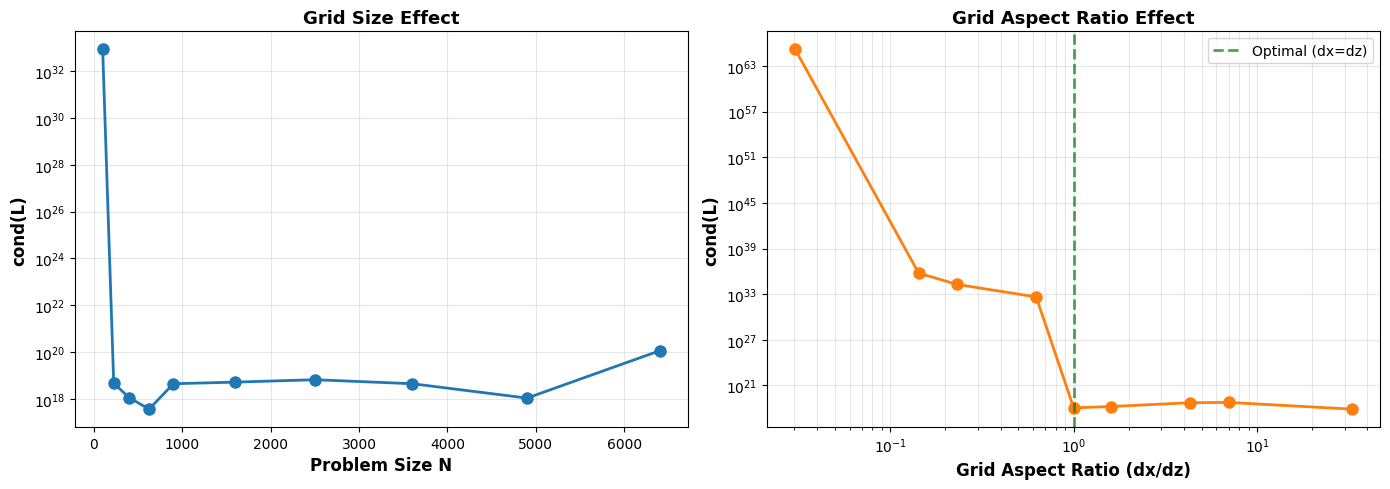

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

print("\nGrid size effect...")
grid_sizes = [(10,10), (15,15), (20,20), (25,25), (30,30), (40,40), (50,50), (60,60), (70,70), (80,80)]
Lx, Lz = 100, 100

N_vals = []
cond_vals = []

for Nx, Nz in grid_sizes:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    N = Nx * Nz
    cond_L = np.linalg.cond(L)
    
    N_vals.append(N)
    cond_vals.append(cond_L)
    print(f"  Grid {Nx}×{Nz} (N={N:5d}): cond = {cond_L:.2e}")

ax1.semilogy(N_vals, cond_vals, 'o-', linewidth=2, markersize=8, color='C0')
ax1.set_xlabel('Problem Size N', fontsize=12, fontweight='bold')
ax1.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax1.set_title('Grid Size Effect', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

print("\nAspect ratio effect (fixed N = 400)...")

aspect_configs = [
    #  N = 400
    (100, 4),
    (50, 8),    
    (40, 10), 
    (25, 16),
    (20, 20), 
    (16, 25),
    (10, 40),  
    (8, 50),   
    (4, 100),   
]

aspect_ratios = []
cond_aspect = []
N_check = []

for Nx, Nz in aspect_configs:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    N = Nx * Nz
    dx, dz = Lx/(Nx-1), Lz/(Nz-1)
    aspect = dx / dz
    cond_L = np.linalg.cond(L)
    
    aspect_ratios.append(aspect)
    cond_aspect.append(cond_L)
    N_check.append(N)
    print(f"  Grid {Nx:3d}×{Nz:3d} (N={N:3d}): dx/dz = {aspect:6.2f}, cond = {cond_L:.2e}")

ax2.loglog(aspect_ratios, cond_aspect, 'o-', linewidth=2, markersize=8, color='C1')
ax2.axvline(1.0, color='g', linestyle='--', linewidth=2, alpha=0.7, label='Optimal (dx=dz)')
ax2.set_xlabel('Grid Aspect Ratio (dx/dz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax2.set_title('Grid Aspect Ratio Effect', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

Absorb = 0.100,  cond(L) = 1.8183e+03
Absorb = 0.500,  cond(L) = 5.8732e+02
Absorb = 1.000,  cond(L) = 4.4958e+02
Absorb = 1.500,  cond(L) = 4.1393e+02
Absorb = 2.000,  cond(L) = 4.0421e+02
Absorb = 2.500,  cond(L) = 4.0523e+02
Absorb = 3.000,  cond(L) = 4.1183e+02
Absorb = 5.000,  cond(L) = 4.6151e+02
Absorb = 10.000,  cond(L) = 6.2824e+02
Absorb = 20.000,  cond(L) = 9.8972e+02
Absorb = 50.000,  cond(L) = 2.0966e+03
Absorb = 100.000,  cond(L) = 3.9489e+03


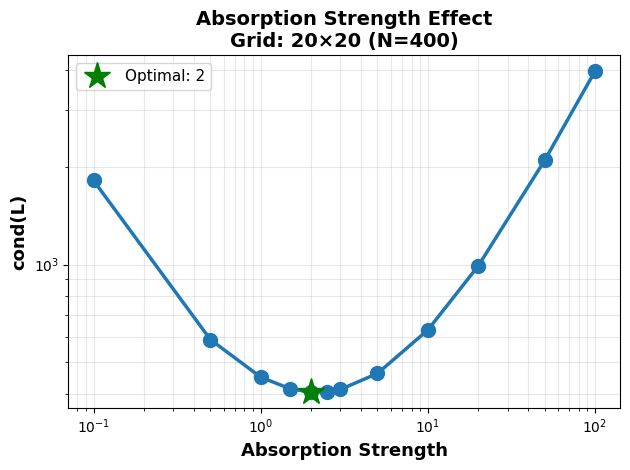

In [7]:
Lx, Lz = 100, 100
Nx, Nz = 20, 20

abs = [0.1, 0.5, 1, 1.5, 2, 2.5, 3, 5, 10, 20, 50, 100]

results = []
for ab in abs:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False, absorb_strength=ab)
    L = extract_L(p)
    N = Nx * Nz
    dx = Lx / (Nx - 1)
    dz = Lz / (Nz - 1)
    
    cond_L = dense_cond(L)
    
    results.append({'Nx': Nx, 'Nz': Nz, 'N': N, 'dx': dx, 'dz': dz, 'cond_L': cond_L})
    print(f"Absorb = {ab:.3f},  cond(L) = {cond_L:.4e}")


absorb_vals = abs
cond_vals = [r['cond_L'] for r in results]

plt.figure()

plt.loglog(absorb_vals, cond_vals, 'o-', linewidth=2.5, markersize=10, color='C0')

# Find minimum
min_idx = np.argmin(cond_vals)
optimal_absorb = absorb_vals[min_idx]
min_cond = cond_vals[min_idx]
plt.plot(optimal_absorb, min_cond, 'g*', markersize=20, 
         label=f'Optimal: {optimal_absorb}')

plt.xlabel('Absorption Strength', fontsize=13, fontweight='bold')
plt.ylabel('cond(L)', fontsize=13, fontweight='bold')
plt.title(f'Absorption Strength Effect\nGrid: {Nx}×{Nz} (N={Nx*Nz})', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, which='both')
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()


What can't effect condition number?


#### Uniform domain scaling (Lx, Ly) → (aLx, aLy)
- **Only causes scalar scaling**
- Both dx and dy scale by factor a
- L ~ 1/dx² + 1/dz² → scales by 1/a²
- cond(CL) = cond(L) for any scalar C ≠ 0
- All eigenvalues scale by same factor → ratio unchanged


#### Sound speed (c)
- **Only causes scalar scaling**
- c only scales L by c²: L_new = (c_new/c_old)² × L_old
- cond(CL) = cond(L) for any scalar 
- All eigenvalues scale by same factor → ratio unchanged


#### Damping (α) 
- **Damping doesn't appead in steady state**
- Neglect dynamics (PM2 requirement):
- dp/dt = 0  →  w = 0
- dw/dt = c²Lp - αIw + bu  →  0 = c²Lp + bu
- Lp = -bu/c²




Uniform domain scaling effect...
  Scale  0.5x (Lx=    5, Lz=    5): cond = 1.14731e+02
  Scale  1.0x (Lx=   10, Lz=   10): cond = 1.14731e+02
  Scale  2.0x (Lx=   20, Lz=   20): cond = 1.14731e+02
  Scale  3.0x (Lx=   30, Lz=   30): cond = 1.14731e+02
  Scale  5.0x (Lx=   50, Lz=   50): cond = 1.14731e+02
  Scale 10.0x (Lx=  100, Lz=  100): cond = 1.14731e+02
  Scale 100.0x (Lx= 1000, Lz= 1000): cond = 1.14731e+02

Sound speed effect...
  c =   50 m/s: cond = 1.14731e+02
  c =  500 m/s: cond = 1.14731e+02
  c = 2000 m/s: cond = 1.14731e+02
  c = 3000 m/s: cond = 1.14731e+02
  c = 10000 m/s: cond = 1.14731e+02

Testing damping effect...
  α = 1e-05: cond = 1.14731e+02
  α = 1e-04: cond = 1.14731e+02
  α = 1e-03: cond = 1.14731e+02
  α = 1e-02: cond = 1.14731e+02
  α = 1e-01: cond = 1.14731e+02


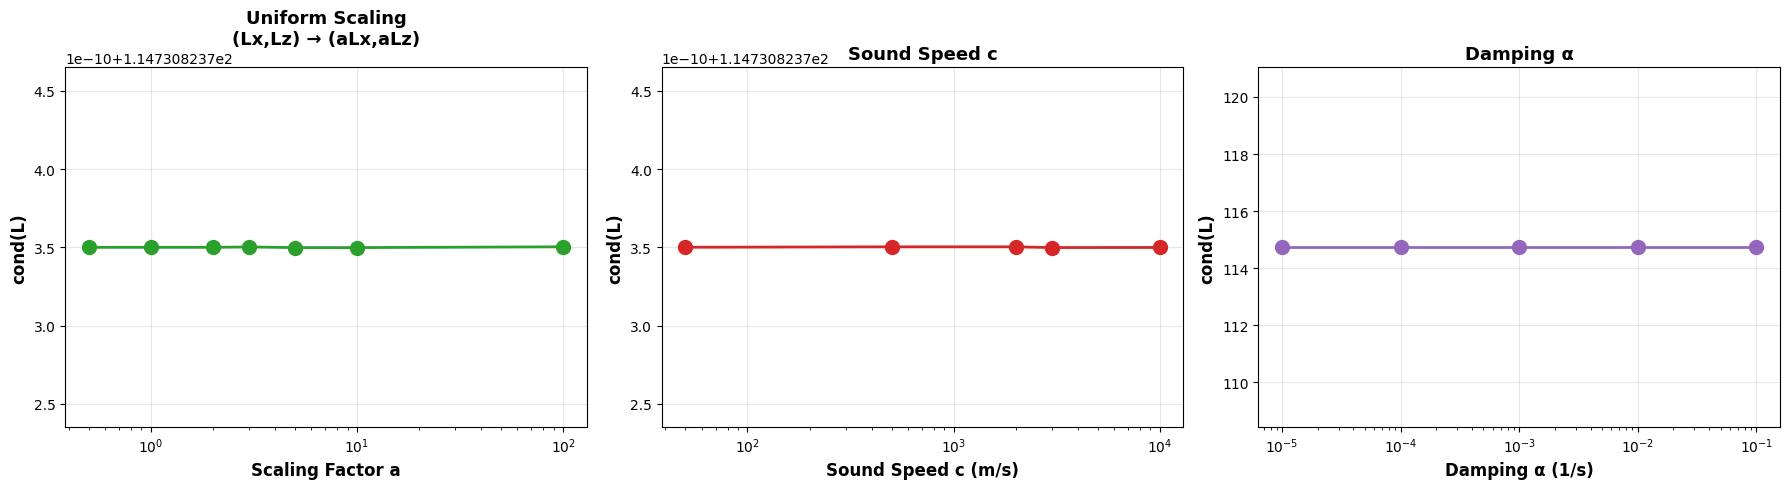

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Uniform Domain Scaling
print("\nUniform domain scaling effect...")
Nx, Nz = 10, 10
scale_factors = [0.5, 1.0, 2.0, 3.0, 5.0, 10.0, 100.0]
cond_scaling = []

for scale in scale_factors:
    Lx, Lz = 10*scale, 10*scale
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    L = extract_L(p)
    cond_L = np.linalg.cond(L)
    cond_scaling.append(cond_L)
    print(f"  Scale {scale:4.1f}x (Lx={Lx:5.0f}, Lz={Lz:5.0f}): cond = {cond_L:.5e}")

ax1.semilogx(scale_factors, cond_scaling, 'o-', linewidth=2, markersize=10, color='C2')
ax1.set_xlabel('Scaling Factor a', fontsize=12, fontweight='bold')
ax1.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax1.set_title('Uniform Scaling\n(Lx,Lz) → (aLx,aLz)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Sound Speed
print("\nSound speed effect...")
Nx, Nz, Lx, Lz = 10, 10, 100, 100
c_values = [50, 500, 2000, 3000, 10000]
cond_sound = []

for c_val in c_values:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    p = rebuild_params_like(p, c=c_val)
    L = extract_L(p)
    cond_L = np.linalg.cond(L)
    cond_sound.append(cond_L)
    print(f"  c = {c_val:4d} m/s: cond = {cond_L:.5e}")

ax2.semilogx(c_values, cond_sound, 'o-', linewidth=2, markersize=10, color='C3')
ax2.set_xlabel('Sound Speed c (m/s)', fontsize=12, fontweight='bold')
ax2.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax2.set_title('Sound Speed c', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Subplot 3: Damping
print("\nTesting damping effect...")
alpha_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
cond_damping = []

for alpha_val in alpha_values:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=True)
    p = rebuild_params_like(p, alpha=alpha_val)
    L = extract_L(p)
    cond_L = np.linalg.cond(L)
    cond_damping.append(cond_L)
    print(f"  α = {alpha_val:.0e}: cond = {cond_L:.5e}")

ax3.semilogx(alpha_values, cond_damping, 'o-', linewidth=2, markersize=10, color='C4')
ax3.set_xlabel('Damping α (1/s)', fontsize=12, fontweight='bold')
ax3.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax3.set_title('Damping α', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Now break and recover


Breaking: Increasing Grid Size...
------------------------------------------------------------
  Nx= 40 (N=  400): cond = 1.26e+03
  Nx= 50 (N=  500): cond = 1.95e+03
  Nx= 60 (N=  600): cond = 2.79e+03
  Nx= 70 (N=  700): cond = 3.79e+03
  Nx= 80 (N=  800): cond = 4.95e+03
  Nx= 90 (N=  900): cond = 6.25e+03
  Nx=100 (N= 1000): cond = 7.72e+03
  Nx=110 (N= 1100): cond = 9.33e+03
  Nx=120 (N= 1200): cond = 1.11e+04

Recovery: Decreasing Grid Size...
------------------------------------------------------------
  Nx=120 (N= 1200): cond = 1.11e+04
  Nx=110 (N= 1100): cond = 9.33e+03
  Nx=100 (N= 1000): cond = 7.72e+03
  Nx= 90 (N=  900): cond = 6.25e+03
  Nx= 80 (N=  800): cond = 4.95e+03
  Nx= 70 (N=  700): cond = 3.79e+03
  Nx= 60 (N=  600): cond = 2.79e+03
  Nx= 50 (N=  500): cond = 1.95e+03
  Nx= 40 (N=  400): cond = 1.26e+03

Breaking: Extreme Aspect Ratios...
------------------------------------------------------------
  dx/dz =  1.00: cond = 1.85e+03 
  dx/dz =  2.00: cond = 5.99e

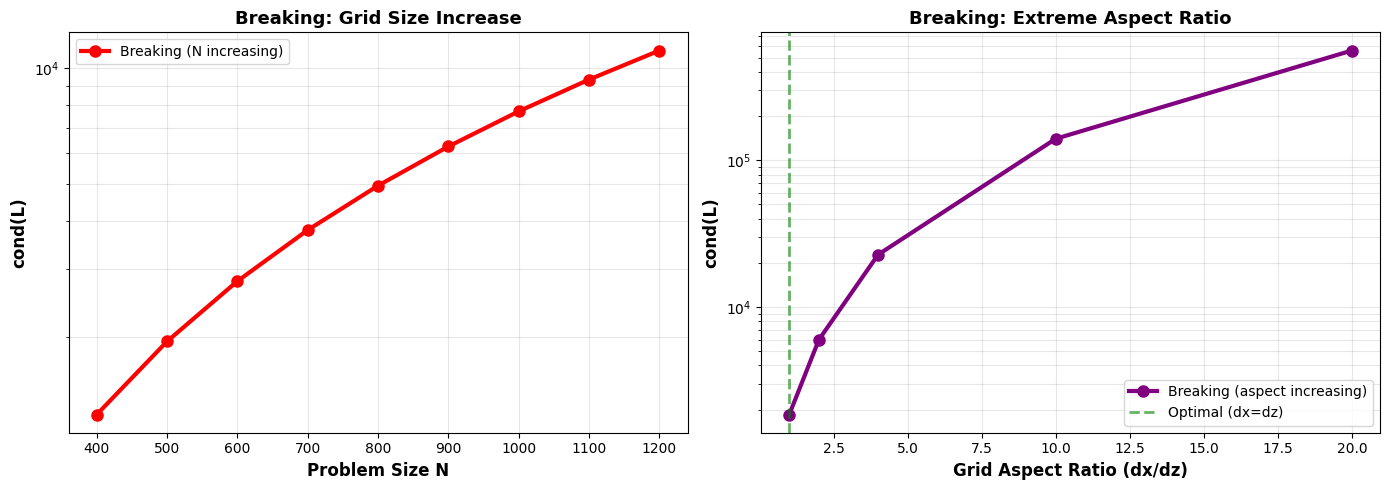

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Breaking: Increase grid size until cond gets large
print("\nBreaking: Increasing Grid Size...")
print("-"*60)
Lx, Lz = 100, 100
Nz = 10
Nx_breaking = [40, 50, 60, 70, 80, 90, 100, 110, 120]

N_breaking = []
cond_breaking = []

for Nx in Nx_breaking:
    N = Nx * Nz
    if N > 3000:
        print(f"  Nx={Nx:3d} (N={N:5d}): Skipped (too large)")
        continue
    
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    cond_L = np.linalg.cond(L)
    
    N_breaking.append(N)
    cond_breaking.append(cond_L)

    print(f"  Nx={Nx:3d} (N={N:5d}): cond = {cond_L:.2e}")

# Recovery: Decrease grid size
print("\nRecovery: Decreasing Grid Size...")
print("-"*60)

Nx_recovery = list(reversed(Nx_breaking[:len(N_breaking)]))
N_recovery = list(reversed(N_breaking))
cond_recovery = list(reversed(cond_breaking))

for i, Nx in enumerate(Nx_recovery):
    print(f"  Nx={Nx:3d} (N={N_recovery[i]:5d}): cond = {cond_recovery[i]:.2e}")

# Plot breaking and recovery
ax1.semilogy(N_breaking, cond_breaking, 'o-', linewidth=3, markersize=8, 
             color='red', label='Breaking (N increasing)')
ax1.set_xlabel('Problem Size N', fontsize=12, fontweight='bold')
ax1.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax1.set_title('Breaking: Grid Size Increase', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, which='both', alpha=0.3)

# Breaking with aspect ratio
print("\nBreaking: Extreme Aspect Ratios...")
print("-"*60)

Nx, Nz = 40, 40
extreme_configs = [
    (100, 100),  # 1:1 baseline
    (100, 50),   # 2:1
    (100, 25),   # 4:1
    (100, 10),   # 10:1
    (100, 5),    # 20:1
]

dx_dz_ratios = []
cond_aspect_break = []

for Lx, Lz in extreme_configs:
    p, *_ = getParam_Sonar(Nx, Nz, Lx, Lz, UseSparseMatrices=False)
    L = extract_L(p)
    dx, dz = Lx/(Nx-1), Lz/(Nz-1)
    ratio = dx / dz
    cond_L = np.linalg.cond(L)
    
    dx_dz_ratios.append(ratio)
    cond_aspect_break.append(cond_L)
    
    print(f"  dx/dz = {ratio:5.2f}: cond = {cond_L:.2e} ")

# Recovery
print("\nRecovery: Returning to Square...")
print("-"*60)

for i in reversed(range(len(extreme_configs))):
    Lx, Lz = extreme_configs[i]
    ratio = dx_dz_ratios[i]
    cond_L = cond_aspect_break[i]
    print(f"  dx/dz = {ratio:5.2f}: cond = {cond_L:.2e}")

ax2.semilogy(dx_dz_ratios, cond_aspect_break, 'o-', linewidth=3, markersize=8,
             color='purple', label='Breaking (aspect increasing)')
ax2.axvline(1.0, color='g', linestyle='--', alpha=0.6, linewidth=2, label='Optimal (dx=dz)')
ax2.set_xlabel('Grid Aspect Ratio (dx/dz)', fontsize=12, fontweight='bold')
ax2.set_ylabel('cond(L)', fontsize=12, fontweight='bold')
ax2.set_title('Breaking: Extreme Aspect Ratio', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()